In [1]:
## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
import json
import glob
from tensorflow.keras.utils import Sequence
from keras_video import VideoFrameGenerator, SlidingFrameGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Dropout, LSTM, Flatten, RNN, LeakyReLU, GRU
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras import backend as K

Using TensorFlow backend.


In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [5]:
classes = ["Real", "Deepfake"]
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 90
batch_size = 16
units = 2
glob_pattern='../Dataset/{classname}/*.mp4'

In [6]:
train = SlidingFrameGenerator(
    batch_size=4, 
    nb_frames=NBFRAME, 
    glob_pattern=glob_pattern, 
    split_val=.2, 
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

class Deepfake, validation count: 310, train count: 1241
class Real, validation count: 344, train count: 1377
Total data: 2 classes for 2618 files for train
Checking files to find possible sequences, please wait...
For 2618 files, I found 238238 possible sequence samples


In [7]:
valid = train.get_validation_generator()

Total data: 2 classes for 654 files for validation
Checking files to find possible sequences, please wait...
For 654 files, I found 59514 possible sequence samples


In [8]:
def base_model(input_shape):
    
    momentum = 0.99
    
    model = tf.keras.Sequential()
    
    model.add(Conv2D(16, (3,3), input_shape=input_shape, padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten
    model.add(GlobalMaxPool2D())
    
    return model

In [9]:
def dfd(input_shape, frames, units):
    base = base_model(input_shape)
        
    model = tf.keras.Sequential()
    
    td_input_shape = frames,*input_shape
    
    model.add(TimeDistributed(base, input_shape=td_input_shape))
    
    model.add(
        TimeDistributed(
            Flatten()
            )
        )
    
    model.add(GRU(256, activation='relu', return_sequences=False))
    
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(.5))
    
    model.add(Dense(units, activation='softmax'))
    
    return model

In [10]:
input_shape = SIZE + (CHANNELS,)

In [11]:
model = dfd(input_shape, NBFRAME, units)

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 90, 32)            17040     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 256)               222720    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 256,338
Trainable params: 256,146
Non-trainable params: 192
______________________________________________

In [13]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision * recall)/(precision + recall + K.epsilon()))

In [14]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ['accuracy', f1_score_m, precision_m, recall_m]
model.compile(optimizer,
              loss = 'categorical_crossentropy',
              metrics = metrics)

In [15]:
epochs=2

callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'Training_chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

In [16]:
history = model.fit(train, validation_data=valid, verbose=1, epochs=epochs, callbacks = callbacks)

Epoch 1/2
59559/59559 [==============================] - 26996s 453ms/step - loss: 0.2305 - accuracy: 0.8915 - f1_score_m: 0.8915 - precision_m: 0.8915 - recall_m: 0.8915 - val_loss: 1.3021 - val_accuracy: 0.7630 - val_f1_score_m: 0.7630 - val_precision_m: 0.7630 - val_recall_m: 0.7630

Epoch 00001: saving model to Training_chkp\weights.01-1.30.hdf5
Epoch 2/2
59559/59559 [==============================] - 27813s 467ms/step - loss: 0.0432 - accuracy: 0.9859 - f1_score_m: 0.9859 - precision_m: 0.9859 - recall_m: 0.9859 - val_loss: 1.6792 - val_accuracy: 0.7095 - val_f1_score_m: 0.7095 - val_precision_m: 0.7095 - val_recall_m: 0.7095

Epoch 00002: saving model to Training_chkp\weights.02-1.68.hdf5


In [17]:
path = 'Weights/model_weights'
model.save_weights(path)

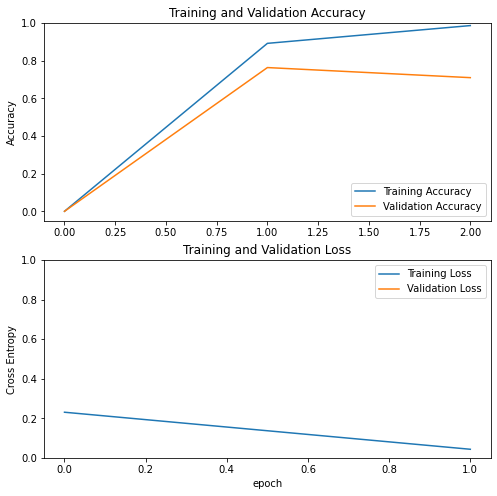

In [20]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
model.save('video_model.h5')

In [22]:
model.evaluate(valid)

14878/14878 [==============================] - 1684s 113ms/step - loss: 1.6791 - accuracy: 0.7095 - f1_score_m: 0.7095 - precision_m: 0.7095 - recall_m: 0.7095


[1.6791229248046875,
 0.7095039486885071,
 0.7095039486885071,
 0.7095039486885071,
 0.7095039486885071]

In [71]:
path = "rawqlgqazkz.mp4"

In [72]:
import cv2
cap = cv2.VideoCapture(path)
print(cap)

<VideoCapture 0000025292244570>


In [73]:
img_array = []
success = 1
i = 1
while success and i <= 90:
    success, img = cap.read()
    img = cv2.resize(img, (112, 112))
    img_array.append(img)
    i += 1

In [74]:
img_array = np.array(img_array)
img_array = img_array.reshape(1, 90, 112, 112, 3)

In [75]:
res = model.predict(img_array).round()
if res[0][0] == 0:
    print("Its Real")
else:
    print("Its Deepfake")

Its Real


In [77]:
print(history.history)

{'loss': [0.23054489493370056, 0.04316355660557747], 'accuracy': [0.8915403485298157, 0.9858669638633728], 'f1_score_m': [0.8915403485298157, 0.9858669638633728], 'precision_m': [0.8915403485298157, 0.9858669638633728], 'recall_m': [0.8915403485298157, 0.9858669638633728], 'val_loss': [1.3020793199539185, 1.6791555881500244], 'val_accuracy': [0.763005793094635, 0.7094703316688538], 'val_f1_score_m': [0.763005793094635, 0.7094703316688538], 'val_precision_m': [0.763005793094635, 0.7094703316688538], 'val_recall_m': [0.763005793094635, 0.7094703316688538], 'lr': [0.001, 0.001]}
